In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder

import joblib

# Set random seed for reproducibility
np.random.seed(42)

## Step 1: Load the features

In [2]:
features_df = pd.read_csv("evse_features.csv")

# Display the first few rows of the feature DataFrame
print("\nFeature DataFrame (first 5 rows):")
print(features_df.head())


Feature DataFrame (first 5 rows):
   sample_index Scenario  instructions  cpu-migrations  mem_access_rd  \
0             0   Attack  4.842734e+08             0.0    182447274.0   
1             1   Attack  3.360893e+08             0.0     83614575.0   
2             2   Attack  2.504586e+08             0.0     62673568.0   
3             3   Attack  3.815842e+08             0.0     61085549.0   
4             4   Attack  2.012276e+09             0.0    464448105.0   

   mem_access_wr  cache-misses  L1-icache-loads  dTLB-store-misses  
0    157319220.0     2113406.0      245241558.0           127193.0  
1     51690301.0     1521862.0      213434196.0           161965.0  
2    123802350.0     1212126.0       69182309.0            18750.0  
3     49477220.0      681121.0      158026571.0           226431.0  
4    344314102.0    11346447.0      943011302.0           776176.0  


## Step 2: Prepare the data

In [3]:
# Map all non-Benign values to Attack
features_df["Scenario"] = features_df["Scenario"].apply(lambda x: "Attack" if x != "Benign" else "Benign")

# Encode the target variable (Scenario) into numeric values (0 = Benign, 1 = Attack)
le = LabelEncoder()
y = le.fit_transform(features_df['Scenario'])
print("\nEncoded labels:", dict(zip(le.classes_, range(len(le.classes_)))))

# Select feature columns (exclude sample_index and Scenario) so that we can create a feature matrix X
X = features_df.drop(columns=['sample_index', 'Scenario'])


Encoded labels: {'Attack': 0, 'Benign': 1}


# Step 3: Split the data into training and testing sets

In [4]:
# use 1/3 of the data for testing and 2/3 for training (stratify=y is used for equal class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 5928 samples
Test set size: 2541 samples


## Step 4: Train the Random Forest model (1/3)

In [5]:
# Define K-Fold Cross-Validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],  # Different numbers of trees
    'max_depth': [10, 20, 30, None],  # Different max depths
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum samples for leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider
    'class_weight': ['balanced', None],  # Class weight options
    'bootstrap': [True, False]  # Whether bootstrap samples are used
}

# Define the model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of random combinations to try
    cv=5,  # Number of folds in cross-validation
    n_jobs=-1,  # Use all CPU cores for cross-validation
    verbose=2,  # Show progress updates
    scoring='accuracy',
    random_state=42
)

# Fit the randomized search
print("\nRunning Randomized Search for Hyperparameter Optimization...")
random_search.fit(X_train, y_train)

# Print the best parameters from RandomizedSearchCV
print("\nBest Hyperparameters:", random_search.best_params_)

# Retrieve the best model from the random search
best_rf_model = random_search.best_estimator_


Running Randomized Search for Hyperparameter Optimization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': None, 'bootstrap': False}


In [6]:
# Perform K-Fold Cross-Validation
cv_scores_rf = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

# Print results
print("K-Fold Cross-Validation Scores (Random Forest):", cv_scores_rf)
print(f"Mean CV Accuracy: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")

K-Fold Cross-Validation Scores (Random Forest): [0.97107438 0.96930342 0.96517119 0.96458087 0.96160662]
Mean CV Accuracy: 0.966 (+/- 0.007)


## Step 5: Evaluate the model on the test set (2/3)


Classification Report (Random Forest):
              precision    recall  f1-score   support

      Attack       0.97      0.98      0.97      1850
      Benign       0.94      0.92      0.93       691

    accuracy                           0.96      2541
   macro avg       0.95      0.95      0.95      2541
weighted avg       0.96      0.96      0.96      2541



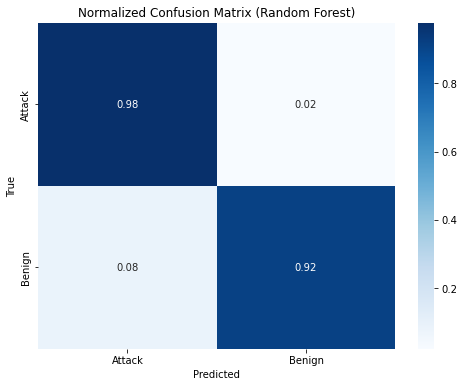

In [7]:
# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Random Forest)')
plt.show()

## Step 6: Feature Importance


Feature Importance:
             Feature  Importance
0       instructions    0.303654
5    L1-icache-loads    0.179833
4       cache-misses    0.169652
2      mem_access_rd    0.128628
3      mem_access_wr    0.113724
6  dTLB-store-misses    0.098764
1     cpu-migrations    0.005746


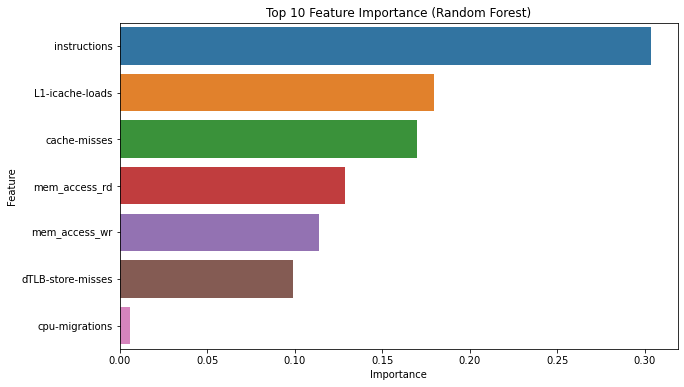

In [8]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance (Random Forest)')
plt.show()

## Step 7: Compute ROC Curve & AUC Score

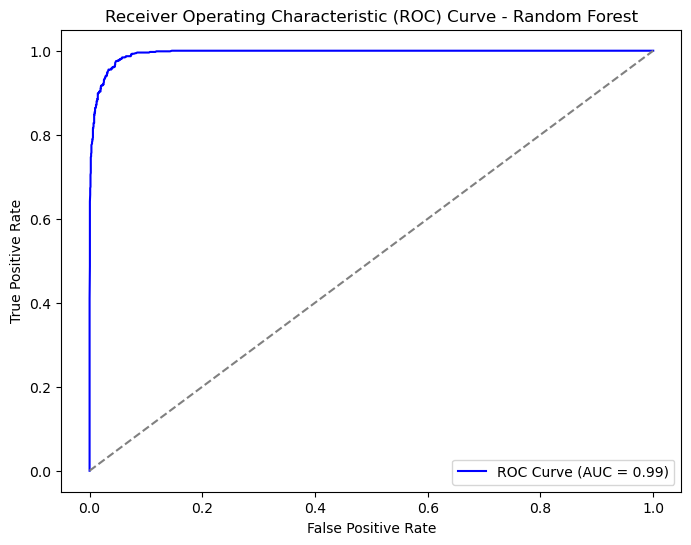

In [18]:
# Get predicted probabilities for positive class (Attack)
y_probs_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Compute ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

## Step 8: Compute Precision-Recall Curve

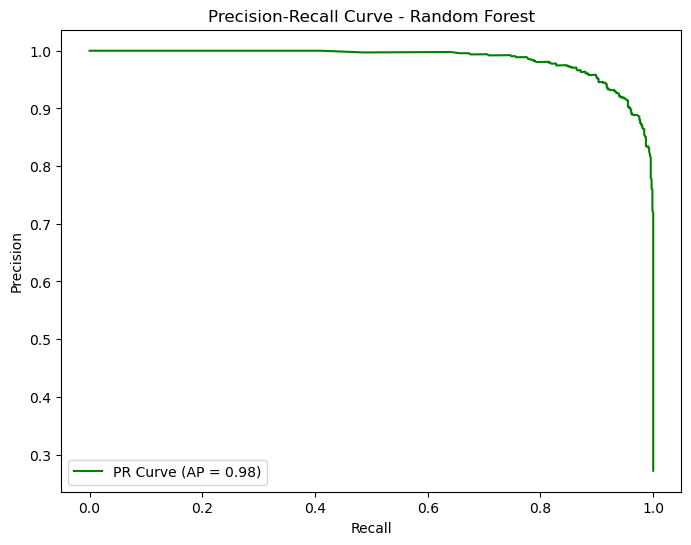

In [19]:
# Compute Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_probs_rf)
avg_precision_rf = average_precision_score(y_test, y_probs_rf)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='green', label=f'PR Curve (AP = {avg_precision_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc='lower left')
plt.show()

## Step 9: Save the trained model and label encoder

In [16]:
joblib.dump(best_rf_model, 'random_forest_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']